## 로지스틱 회귀분석

### 관련 라이브러리 호출

In [1]:
# 관련 라이브러리를 호출합니다.
import os
import joblib
import numpy as np
import pandas as pd

In [6]:
import sys
sys.path

['C:\\Users\\hdsce\\Documents\\PythonDataAnalysis2\\live',
 'C:\\Users\\hdsce\\Documents\\MyPath',
 'C:\\Users\\hdsce\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip',
 'C:\\Users\\hdsce\\AppData\\Local\\Programs\\Python\\Python311\\DLLs',
 'C:\\Users\\hdsce\\AppData\\Local\\Programs\\Python\\Python311\\Lib',
 'C:\\Users\\hdsce\\AppData\\Local\\Programs\\Python\\Python311',
 'C:\\Users\\hdsce\\ve311',
 '',
 'C:\\Users\\hdsce\\ve311\\Lib\\site-packages',
 'C:\\Users\\hdsce\\ve311\\Lib\\site-packages\\win32',
 'C:\\Users\\hdsce\\ve311\\Lib\\site-packages\\win32\\lib',
 'C:\\Users\\hdsce\\ve311\\Lib\\site-packages\\Pythonwin']

In [2]:
# 시각화 설정 모듈을 호출합니다.
from GraphicSetting import *

In [3]:
# 통계 관련 라이브러리를 호출합니다.
from scipy import stats
import pingouin as pg

In [4]:
# EDA 시각화 및 통계 분석 관련 모듈을 호출합니다.
import hds_stats as hds

In [5]:
# 실수를 출력할 소수점 자릿수를 설정합니다.
%precision 3
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

### 실습 데이터셋 준비

In [8]:
# 인터넷에 공유 중인 텍스트 데이터를 읽고 데이터프레임 df를 생성합니다.
df = pd.read_csv(filepath_or_buffer = 'https://bit.ly/UnivAdmit')

In [9]:
# df의 정보를 확인합니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687 entries, 0 to 1686
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   admit   1687 non-null   object 
 1   gre     1687 non-null   float64
 2   gpa     1687 non-null   float64
 3   rank    1687 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 52.8+ KB


In [10]:
# df의 처음 5행을 출력합니다.
df.head()

,admit,gre,gpa,rank
0,Fail,380.000,3.610,3
1,Pass,660.000,3.670,3
2,Pass,800.000,4.000,1
3,Pass,640.000,3.190,4
4,Fail,520.000,2.930,4


In [11]:
# y절편 역할을 수행할 상수 1을 df의 두 번째 열로 삽입합니다.
df.insert(loc = 1, column = 'const', value = 1)

### 실습 데이터셋 전처리

In [12]:
# rank를 범주형으로 변환합니다.
df['rank'] = df['rank'].astype(str)

In [13]:
# 연속형 변수의 기술통계량을 확인합니다.
df.describe()

,const,gre,gpa
count,1687.000,1687.000,1687.000
mean,1.000,574.303,3.346
std,0.000,97.924,0.322
min,1.000,220.000,2.260
25%,1.000,510.000,3.130
50%,1.000,580.000,3.360
75%,1.000,640.000,3.580
max,1.000,800.000,4.000


In [14]:
# 범주형 변수의 기술통계량을 확인합니다.
df.describe(include = object)

,admit,rank
count,1687,1687
unique,2,4
top,Fail,2
freq,1163,568


In [15]:
# rank의 범주별 빈도수를 출력합니다.
df['rank'].value_counts().sort_index()

rank
1    273
2    568
3    540
4    306
Name: count, dtype: int64

### 목표변수 시각화

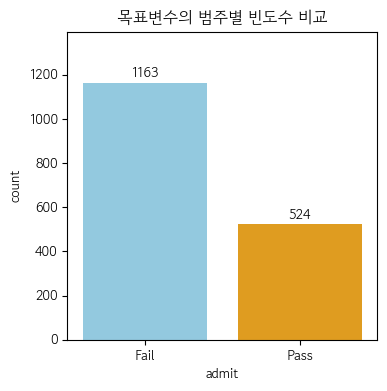

In [16]:
# 목표변수 범주별 빈도수로 일변량 막대 그래프를 그립니다.
hds.plot.bar_freq(
    data = df, 
    x = 'admit', 
    pal = ['skyblue', 'orange']
)

### 입력변수와 관계 파악: gre

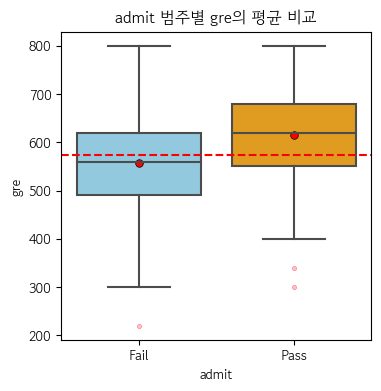

In [17]:
# admit 범주별 gre의 상자 수염 그림을 그립니다.
hds.plot.box_group(
    data = df, 
    x = 'admit', 
    y = 'gre', 
    pal = ['skyblue', 'orange']
)

### 입력변수와 관계 파악: gpa

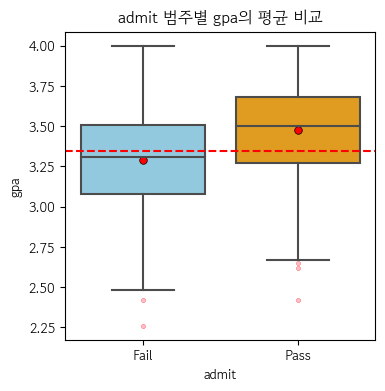

In [18]:
# admit 범주별 gpa의 상자 수염 그림을 그립니다.
hds.plot.box_group(
    data = df, 
    x = 'admit', 
    y = 'gpa', 
    pal = ['skyblue', 'orange']
)

### 입력변수와 관계 파악: rank

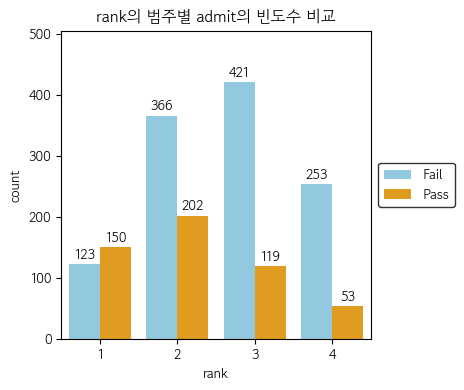

In [19]:
# rank 범주별 admit의 빈도수로 묶음 막대 그래프를 그립니다.
hds.plot.bar_dodge_freq(
    data = df, 
    x = 'rank', 
    group = 'admit', 
    pal = ['skyblue', 'orange']
)

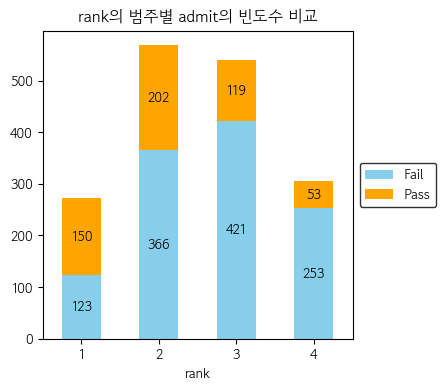

In [20]:
# rank 범주별 admit의 빈도수로 쌓은 막대 그래프를 그립니다.
hds.plot.bar_stack_freq(
    data = df, 
    x = 'rank', 
    group = 'admit', 
    pal = ['skyblue', 'orange']
)

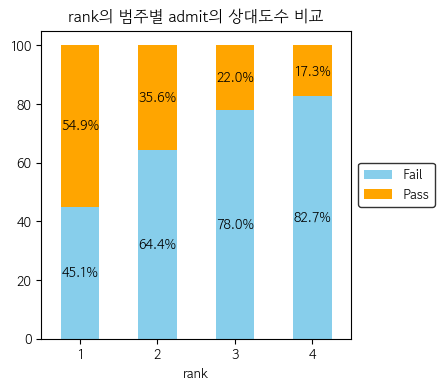

In [21]:
# rank 범주별 admit의 상대도수로 쌓은 막대 그래프를 그립니다.
hds.plot.bar_stack_prop(
    data = df, 
    x = 'rank', 
    group = 'admit', 
    pal = ['skyblue', 'orange']
);

### t-검정: gre

In [22]:
# (정규성 가정 만족) 등분산 검정을 실행합니다.
pg.homoscedasticity(data = df, dv = 'gre', group = 'admit')

,W,pval,equal_var
levene,3.596,0.058,True


In [23]:
# admit 범주별 gre로 시리즈를 생성합니다.
sp1 = df['gre'][df['admit'].eq('Fail')]
sp2 = df['gre'][df['admit'].eq('Pass')]

In [24]:
df.groupby(by = ['admit'])['gre'].mean()

admit
Fail   556.079
Pass   614.752
Name: gre, dtype: float64

In [25]:
# (정규성 가정 만족) 등분산 가정된 독립표본 t-검정을 실행합니다.
pg.ttest(x = sp1, y = sp2, correction = False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-11.849,1685,two-sided,0.000,"[-68.38, -48.96]",0.623,6.726e+27,1.000


### t-검정 : gpa

In [26]:
# (정규성 가정 만족) 등분산 검정을 실행합니다.
pg.homoscedasticity(data = df, dv = 'gpa', group = 'admit')

,W,pval,equal_var
levene,0.678,0.410,True


In [27]:
# admit 범주별 gpa로 시리즈를 생성합니다.
sp1 = df['gpa'][df['admit'].eq('Fail')]
sp2 = df['gpa'][df['admit'].eq('Pass')]

In [28]:
df.groupby(by = ['admit'])['gpa'].mean()

admit
Fail   3.288
Pass   3.475
Name: gpa, dtype: float64

In [29]:
# (정규성 가정 만족) 등분산 가정된 독립표본 t-검정을 실행합니다.
pg.ttest(x = sp1, y = sp2, correction = False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-11.505,1685,two-sided,0.000,"[-0.22, -0.16]",0.605,1.664e+26,1.000


### 교차분석: rank

In [30]:
# 범주형 입력변수 rank와 목표변수의 교차테이블을 출력합니다.
pd.crosstab(index = df['rank'], 
            columns = df['admit'], 
            normalize = 'index', 
            margins = True)

admit,Fail,Pass
rank,,
1,0.451,0.549
2,0.644,0.356
3,0.780,0.220
4,0.827,0.173
All,0.689,0.311


In [31]:
# 교차테이블 빈도수로 교차분석(카이제곱 검정)을 실행합니다.
pg.chi2_independence(data = df, x = 'rank', y = 'admit')

(admit    Fail    Pass
 rank                 
 1     188.203  84.797
 2     391.573 176.427
 3     372.270 167.730
 4     210.953  95.047,
 admit  Fail  Pass
 rank             
 1       123   150
 2       366   202
 3       421   119
 4       253    53,
                  test  lambda    chi2   dof  pval  cramer  power
 0             pearson   1.000 125.621 3.000 0.000   0.273  1.000
 1        cressie-read   0.667 124.434 3.000 0.000   0.272  1.000
 2      log-likelihood   0.000 123.671 3.000 0.000   0.271  1.000
 3       freeman-tukey  -0.500 124.457 3.000 0.000   0.272  1.000
 4  mod-log-likelihood  -1.000 126.396 3.000 0.000   0.274  1.000
 5              neyman  -2.000 133.872 3.000 0.000   0.282  1.000)

### 더미변수 생성

In [35]:
pd.get_dummies(data = df, prefix = [None, 'rank'], 
               columns = ['admit', 'rank'], drop_first = True, 
               dtype = 'int64')

,const,gre,gpa,Pass,rank_2,rank_3,rank_4
0,1,380.000,3.610,0,0,1,0
1,1,660.000,3.670,1,0,1,0
2,1,800.000,4.000,1,0,0,0
3,1,640.000,3.190,1,0,0,1
4,1,520.000,2.930,0,0,0,1
...,...,...,...,...,...,...,...
1682,1,450.000,2.950,0,1,0,0
1683,1,480.000,3.040,0,0,1,0
1684,1,670.000,3.670,0,0,1,0
1685,1,530.000,3.210,0,1,0,0


In [36]:
# 범주형 입력변수로 더미변수를 생성합니다.
df = pd.get_dummies(data = df, prefix = ['rank', None], 
                    columns = ['rank', 'admit'], 
                    drop_first = True, dtype = 'int64')

In [37]:
# df의 처음 10행을 출력합니다.
df.head(n = 10)

,const,gre,gpa,rank_2,rank_3,rank_4,Pass
0,1,380.000,3.610,0,1,0,0
1,1,660.000,3.670,0,1,0,1
2,1,800.000,4.000,0,0,0,1
3,1,640.000,3.190,0,0,1,1
4,1,520.000,2.930,0,0,1,0
5,1,760.000,3.000,1,0,0,1
6,1,560.000,2.980,0,0,0,1
7,1,400.000,3.080,1,0,0,0
8,1,540.000,3.390,0,1,0,1
9,1,700.000,3.920,1,0,0,0


In [38]:
# 목표변수명을 'admit'으로 변경합니다.
df = df.rename(columns = {'Pass': 'admit'})

### 실습 데이터셋 분할

In [39]:
# 관련 라이브러리를 호출합니다.
from sklearn.model_selection import train_test_split

In [40]:
# 전체 데이터의 70%를 훈련셋, 30%를 시험셋으로 분할합니다.
trSet, teSet = train_test_split(df, test_size = 0.3, random_state = 0)

In [41]:
# 훈련셋의 목표변수 범주별 상대도수를 확인합니다.
trSet['admit'].value_counts(normalize = True)

admit
0   0.692
1   0.308
Name: proportion, dtype: float64

In [42]:
# 시험셋의 목표변수 범주별 상대도수를 확인합니다.
teSet['admit'].value_counts(normalize = True)

admit
0   0.684
1   0.316
Name: proportion, dtype: float64

### 입력변수와 목표변수 분리

In [43]:
# 목표변수명을 변수에 할당합니다.
yvar = 'admit'

In [44]:
# 훈련셋을 목표변수 벡터와 입력변수 행렬로 분리합니다.
trReal = trSet[yvar].copy()
trSetX = trSet.drop(columns = [yvar])

In [45]:
# 시험셋을 목표변수 벡터와 입력변수 행렬로 분리합니다.
teReal = teSet[yvar].copy()
teSetX = teSet.drop(columns = [yvar])

### 로지스틱 회귀모형 적합 및 결과 확인

In [46]:
# 훈련셋으로 로지스틱 회귀모형을 적합합니다.
fit1 = hds.stat.glm(y = trReal, X = trSetX)

In [47]:
# fit1 모형의 적합 결과를 확인합니다.
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  admit   No. Observations:                 1180
Model:                            GLM   Df Residuals:                     1174
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -637.55
Date:                Fri, 21 Apr 2023   Deviance:                       1275.1
Time:                        15:27:32   Pearson chi2:                 1.16e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1437
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.2059      0.858     -7.235      0.000      -7.887      -4.525
gre            0.0040      0.001      3.399      0.001       0.002       0.006
gpa            1.1545      0.363      3.183      0.001       0.444       1.865
rank_2        -0.6268      0.189     -3.323      0.001      -0.997      -0.257
rank_3        -1.3495      0.201     -6.716      0.000      -1.743      -0.956
rank_4        -1.6492      0.247     -6.687      0.000      -2.133      -1.166
==============================================================================
"""

### 로지스틱 회귀모형의 유의성 검정

In [48]:
# 두 모형의 이탈도 차이를 출력합니다.(검정통계량)
devGap = fit1.null_deviance - fit1.deviance
devGap

183.080

In [49]:
# 두 모형의 자유도 차이를 출력합니다.(카이제곱 분포의 자유도)
dofGap = fit1.df_model
dofGap

5

In [50]:
# 검정통계량과 자유도로 유의확률을 출력합니다.
1 - stats.chi2.cdf(x = devGap, df = dofGap)

0.000

### 다중공선성 확인

In [51]:
# 분산팽창지수를 출력하고 다중공선성 입력변수를 확인합니다.
hds.stat.vif(X = trSetX)

,gre,gpa,rank_2,rank_3,rank_4
0,2.832,2.816,2.052,2.042,1.734


### 오즈비 확인

In [53]:
fit1.params

const    -6.206
gre       0.004
gpa       1.154
rank_2   -0.627
rank_3   -1.349
rank_4   -1.649
dtype: float64

In [52]:
# 입력변수별 회귀계수의 오즈비를 출력합니다.
np.exp(fit1.params)

const    0.002
gre      1.004
gpa      3.172
rank_2   0.534
rank_3   0.259
rank_4   0.192
dtype: float64

### 표준화 회귀계수 확인

In [54]:
# fit1 모형의 회귀계수를 출력합니다.
fit1.params

const    -6.206
gre       0.004
gpa       1.154
rank_2   -0.627
rank_3   -1.349
rank_4   -1.649
dtype: float64

In [55]:
# 표준화 회귀계수를 생성합니다.
beta_z = hds.stat.std_coefs(model = fit1)
beta_z

const    -0.000
gre       0.397
gpa       0.367
rank_2   -0.297
rank_3   -0.631
rank_4   -0.628
dtype: float64

In [56]:
# 표준화 회귀계수의 절대값을 오름차순 정렬한 결과를 출력합니다.
beta_z.abs().sort_values()

const    0.000
rank_2   0.297
gpa      0.367
gre      0.397
rank_4   0.628
rank_3   0.631
dtype: float64

### 목표변수의 추정확률 생성

In [57]:
# 훈련셋으로 fit1 모형의 추정확률을 생성하고 실제값과 비교합니다.
trProb = fit1.predict(exog = trSetX)
pd.DataFrame(data = {'Real': trReal, 'Prob': trProb})

,Real,Prob
1679,0,0.481
519,0,0.177
522,0,0.142
140,0,0.571
878,0,0.348
...,...,...
835,0,0.329
1216,1,0.320
1653,1,0.604
559,0,0.349


In [58]:
# 시험셋으로 fit1 모형의 추정확률을 생성하고 실제값과 비교합니다.
teProb = fit1.predict(exog = teSetX)
pd.DataFrame(data = {'Real': teReal, 'Prob': teProb})

,Real,Prob
34,0,0.244
740,1,0.374
638,0,0.269
901,0,0.286
1188,1,0.444
...,...,...
1017,0,0.490
568,0,0.349
362,0,0.386
904,0,0.289


### 분류모형 성능 평가 : ROC 곡선

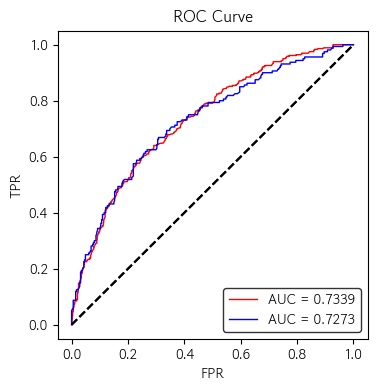

In [59]:
# 훈련셋과 시험셋의 추정확률로 ROC 곡선을 그립니다.
hds.stat.roc_curve(y_true = trReal, y_prob = trProb, color = 'red')
hds.stat.roc_curve(y_true = teReal, y_prob = teProb, color = 'blue')

### 목표변수의 추정값 생성

In [60]:
# 분리 기준점을 0.5로 설정합니다.
cutoff = 0.5

In [61]:
# 훈련셋의 목표변수 추정값(라벨)을 생성합니다.
trPred1 = np.where(trProb >= cutoff, 1, 0)

In [62]:
# 시험셋의 목표변수 추정값(라벨)을 생성합니다.
tePred1 = np.where(teProb >= cutoff, 1, 0)

### 분류모형 성능 평가 : 혼동행렬 리포트

In [63]:
# 훈련셋 추정값으로 혼동행렬 리포트를 출력합니다.
hds.stat.clfmetrics(y_true = trReal, y_pred = trPred1)

▶ Confusion Matrix
[[739  77]
 [246 118]]

▶ Classification Report
              precision    recall  f1-score   support

           0     0.7503    0.9056    0.8207       816
           1     0.6051    0.3242    0.4222       364

    accuracy                         0.7263      1180
   macro avg     0.6777    0.6149    0.6214      1180
weighted avg     0.7055    0.7263    0.6977      1180



In [64]:
# 시험셋 추정값으로 혼동행렬 리포트를 출력합니다.
hds.stat.clfmetrics(y_true = teReal, y_pred = tePred1)

▶ Confusion Matrix
[[316  31]
 [108  52]]

▶ Classification Report
              precision    recall  f1-score   support

           0     0.7453    0.9107    0.8197       347
           1     0.6265    0.3250    0.4280       160

    accuracy                         0.7258       507
   macro avg     0.6859    0.6178    0.6238       507
weighted avg     0.7078    0.7258    0.6961       507



### [참고] 혼동행렬 관련 함수

In [65]:
# 관련 라이브러리를 호출합니다.
from sklearn import metrics

In [66]:
# 시험셋 추정값으로 혼동행렬을 출력합니다.
print(metrics.confusion_matrix(y_true = teReal, y_pred = tePred1))

[[316  31]
 [108  52]]


In [67]:
# 시험셋 추정값으로 분류모형 리포트를 출력합니다.
print(metrics.classification_report(y_true = teReal, y_pred = tePred1))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82       347
           1       0.63      0.33      0.43       160

    accuracy                           0.73       507
   macro avg       0.69      0.62      0.62       507
weighted avg       0.71      0.73      0.70       507



In [68]:
# 시험셋 추정값으로 F1 점수를 출력합니다.
metrics.f1_score(y_true = teReal, y_pred = tePred1, pos_label = 1)

0.428

### [참고] 목표변수의 범주별 추정확률 분포

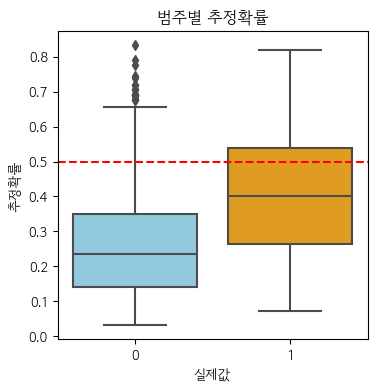

In [69]:
# 목표변수 범주별 추정확률 분포를 비교합니다.
sns.boxplot(x = trReal, y = trProb)
plt.title(label = '범주별 추정확률')
plt.xlabel(xlabel = '실제값')
plt.ylabel(ylabel = '추정확률')
plt.axhline(y = 0.5, color = 'red', lw = 1.5, ls = '--');

### [참고] 최적의 분리 기준점 탐색

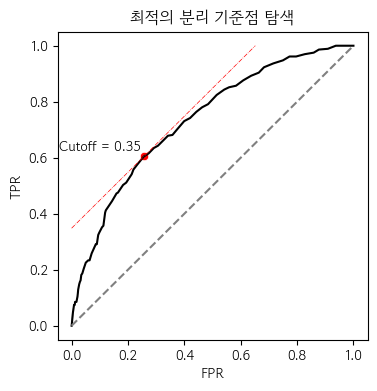

In [70]:
# 분리 기준점마다 민감도와 특이도를 계산하고 두 값의 합계가 최댓값일 때의 
# 분리 기준점을 ROC 곡선 위에 빨간 점으로 표시합니다.
hds.stat.EpiROC(y_true = trReal, y_prob = trProb)

### [참고] 최적의 분리 기준점으로 성능지표 확인

In [71]:
# 최적의 분리 기준점을 설정합니다.
cutoff = 0.35

In [72]:
# 분리 기준점 변경 후 시험셋의 목표변수 추정값(라벨)을 생성합니다.
tePred2 = np.where(teProb >= cutoff, 1, 0)

In [73]:
# 분리 기준점 변경 후 시험셋 추정값으로 혼동행렬 리포트를 출력합니다.
hds.stat.clfmetrics(y_true = teReal, y_pred = tePred2)

▶ Confusion Matrix
[[264  83]
 [ 66  94]]

▶ Classification Report
              precision    recall  f1-score   support

           0     0.8000    0.7608    0.7799       347
           1     0.5311    0.5875    0.5579       160

    accuracy                         0.7061       507
   macro avg     0.6655    0.6742    0.6689       507
weighted avg     0.7151    0.7061    0.7098       507



In [74]:
# 분리 기준점 변경 전 시험셋 추정값으로 혼동행렬 리포트와 비교합니다.
hds.stat.clfmetrics(y_true = teReal, y_pred = tePred1)

▶ Confusion Matrix
[[316  31]
 [108  52]]

▶ Classification Report
              precision    recall  f1-score   support

           0     0.7453    0.9107    0.8197       347
           1     0.6265    0.3250    0.4280       160

    accuracy                         0.7258       507
   macro avg     0.6859    0.6178    0.6238       507
weighted avg     0.7078    0.7258    0.6961       507



### [참고] 매튜의 상관계수

In [75]:
# 분리 기준점 변경 전 시험셋 추정값으로 매튜의 상관계수를 출력합니다.
metrics.matthews_corrcoef(y_true = teReal, y_pred = tePred1)

0.296

In [76]:
# 분리 기준점 변경 후 시험셋 추정값으로 매튜의 상관계수와 비교합니다.
metrics.matthews_corrcoef(y_true = teReal, y_pred = tePred2)

0.340

In [77]:
cutoffs = np.arange(0.0, 1.01, 0.01)

In [79]:
mccs = []
for cutoff in cutoffs:
    tePred = np.where(teProb >= cutoff, 1, 0)
    mccs.append(metrics.matthews_corrcoef(y_true = teReal, y_pred = tePred))

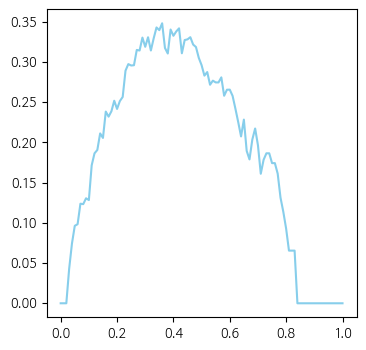

In [80]:
sns.lineplot(x = cutoffs, y = mccs);

In [81]:
np.argmax(mccs)

36

In [82]:
mccs[36]

0.348

In [83]:
cutoffs[36]

0.360

## End of Document